/var/folders/87/d5l9b5f52ml6sfqqmvcwv0jr0000gn/T/ipykernel_10219/4263113828.py:35: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  nutrient_layer = PropertyLayer("nutrient",width,height,default_value=0)


1241.3450305550857


[Text(0.5, 1.0, 'Nutrient distribution')]

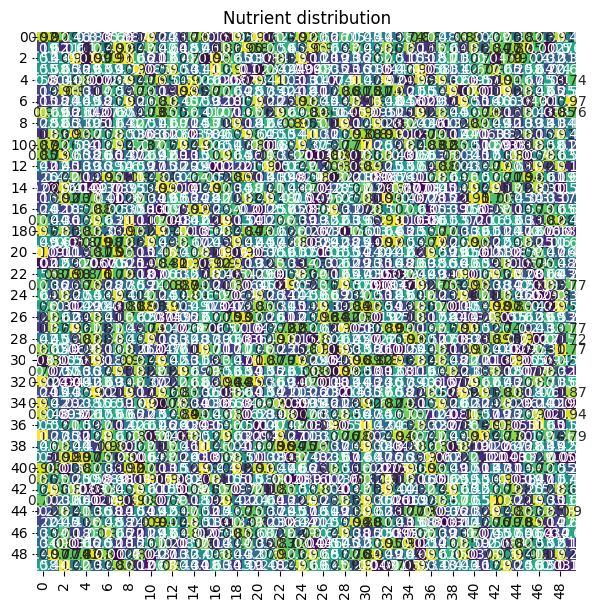

In [2]:
import mesa
from mesa.space import PropertyLayer
import numpy as np 
import seaborn as sns
import pandas as pd
import copy

class BacteriaAgent(mesa.Agent):
    def __init__(self, unique_id, model, uptake_rate):
        super().__init__(unique_id, model)
        self.uptake_rate = uptake_rate # added
    
    def step(self):
        self.uptake_nutrient()
        # pass

    def uptake_nutrient(self):
        # Get the current cell of the bacterium
        x, y = self.pos
        # Get the current nutrient level in this cell
        nutrient = self.model.grid.properties["nutrient"].data[x][y]
        # Uptake only the available nutrients
        # Subtract the uptaken nutrients from the nutrient level in the cell
        self.model.grid.properties["nutrient"].data[x][y] -= min(self.uptake_rate * nutrient, nutrient)
        return nutrient

class SimModel(mesa.Model):
    def __init__(self, width, height, uptake_rate=0.1): # changed
        super().__init__()
        self.num_agents = 10
        self.diffusion_coefficient = 0.1
        
        # Initialize Grid Properties
        self.grid = mesa.space.MultiGrid(width,height,True)
        nutrient_layer = PropertyLayer("nutrient",width,height,default_value=0)
        nutrient_layer.modify_cells(lambda x: np.random.random())
        self.grid.add_property_layer(nutrient_layer)
        
        # Initialize Scheduler
        self.schedule = mesa.time.RandomActivation(self)
       
        # Initialize Agents
        for i in range(self.num_agents):
            a = BacteriaAgent(i,self, uptake_rate) # changed
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
    
    def step(self):
        self.schedule.step()
        # Vectorized version should have a major speedup
        # Runtime went from 75 seconds to 5 seconds for 1000 steps
        self.diffuse_nutrients_vectorized()
        #self.diffuse_nutrients()

    # For profiling purposes only
    def step2(self):
        self.diffuse_nutrients()
        
    def diffuse_nutrients(self):
        new_nutrient_distribution = np.copy(self.grid.properties["nutrient"].data)

        for x in range(self.grid.width):
            for y in range(self.grid.height):
                for dx in [-1, 0, 1]:
                    for dy in [-1, 0, 1]:
                        if dx == 0 and dy == 0: continue  # Skip self
                        x2 = (x + dx) % self.grid.width
                        y2 = (y + dy) % self.grid.height
                        diff = (self.grid.properties["nutrient"].data[x2][y2] -
                                self.grid.properties["nutrient"].data[x][y])
                        if dx == 0 or dy == 0:  # Adjacent
                            transfer = diff * self.diffusion_coefficient
                        else:  # Diagonal
                            transfer = (diff * self.diffusion_coefficient) / np.sqrt(2)
                        new_nutrient_distribution[x][y] += transfer
                        new_nutrient_distribution[x2][y2] -= transfer
        
        self.grid.properties["nutrient"].data = new_nutrient_distribution

    def diffuse_nutrients_vectorized(self):
        # Extract the current nutrient grid for convenience
        nutrient_grid = self.grid.properties["nutrient"].data
        
        # Create padded grid to handle edge wrapping more easily
        padded = np.pad(nutrient_grid, pad_width=1, mode='wrap')
        
        # Calculate the diffusion from each cell to its neighbors
        # For direct neighbors
        direct_diffusion = padded[1:-1, :-2] + padded[1:-1, 2:] + padded[:-2, 1:-1] + padded[2:, 1:-1] - 4 * nutrient_grid
        # For diagonal neighbors, adjusted by 1/sqrt(2)
        diagonal_diffusion = (padded[:-2, :-2] + padded[:-2, 2:] + padded[2:, :-2] + padded[2:, 2:] - 4 * nutrient_grid) / np.sqrt(2)
        
        # Sum of both diffusion effects
        total_diffusion = direct_diffusion + diagonal_diffusion
        
        # Apply the diffusion coefficient
        nutrient_grid += total_diffusion * self.diffusion_coefficient
    
        # Update the nutrient grid
        self.grid.properties["nutrient"].data = nutrient_grid

        
model = SimModel(50,50, uptake_rate=0.1) # changed
# For profiling purposes
#model2 = copy.deepcopy(model)
amount = 0
nutrient_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    amount += model.grid.properties["nutrient"].data[x][y]
    nutrient_counts[x][y] = model.grid.properties["nutrient"].data[x][y]
print(amount)
g = sns.heatmap(nutrient_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(7, 7)
g.set(title="Nutrient distribution")


1252.3204062554598


[Text(0.5, 1.0, 'Nutrient distribution')]

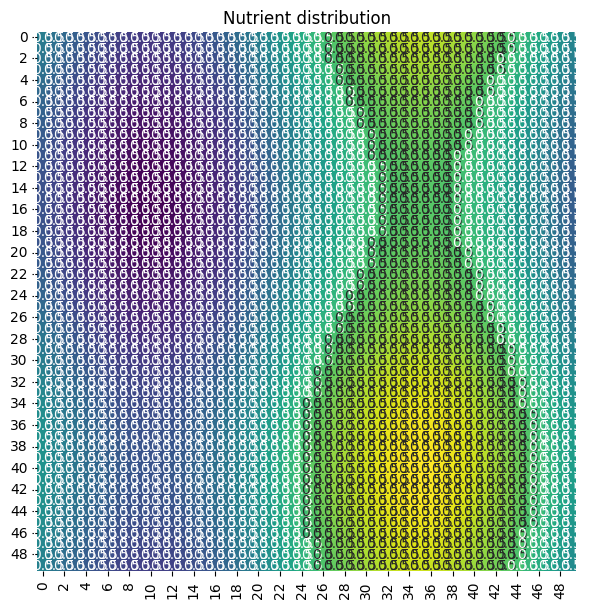

In [174]:
for _ in range(1):
    model.step()
amount = 0
nutrient_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    amount += model.grid.properties["nutrient"].data[x][y]
    nutrient_counts[x][y] = model.grid.properties["nutrient"].data[x][y]
print(amount)
g = sns.heatmap(nutrient_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(7, 7)
g.set(title="Nutrient distribution")

[Text(0.5, 1.0, 'Agent Dis')]

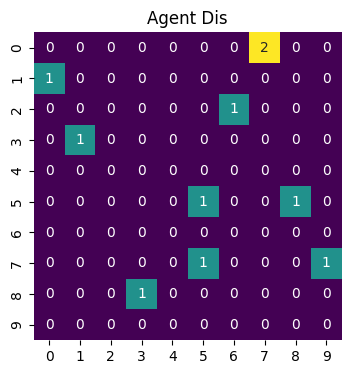

In [71]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
f = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
f.figure.set_size_inches(4, 4)
f.set(title="Agent Dis")

Testing if uptake_nutrient function is working: Note that there is a decrease in nutrient levels in the cells where the bacteria agents are located

/var/folders/87/d5l9b5f52ml6sfqqmvcwv0jr0000gn/T/ipykernel_10219/4263113828.py:35: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  nutrient_layer = PropertyLayer("nutrient",width,height,default_value=0)


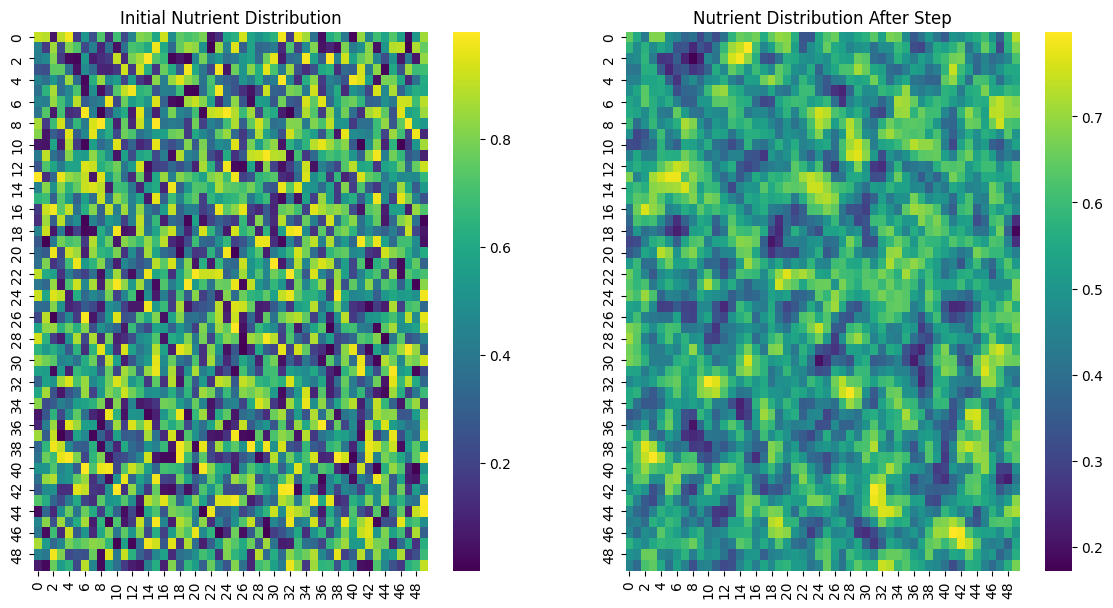

In [3]:
import matplotlib.pyplot as plt

# Create the model
model = SimModel(50, 50, uptake_rate=0.1)

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Plot the initial nutrient distribution
sns.heatmap(model.grid.properties["nutrient"].data, cmap="viridis", ax=axs[0])
axs[0].set_title("Initial Nutrient Distribution")

# Run the model step
model.step()

# Plot the nutrient distribution after running the model step
sns.heatmap(model.grid.properties["nutrient"].data, cmap="viridis", ax=axs[1])
axs[1].set_title("Nutrient Distribution After Step")

# Show the figure
plt.show()